# WTTE-pipeline : data-munging template


Simple pipeline. Take by-timestamp records-data, aggregate over larger timeinterval (discretize) and reshape to tensor. 


# Example pipe

FLOW :
1. Munge df ( want id,time to be unique keys)
2. Decide on what happens between observed timesteps
    * Discrete time:
        * Pad between timesteps (use t_elapsed) or not (use t_ix) 
    * Continuous time:
        * Do not pad between timesteps as 'step' is undefined.
3. Embed in fix-format tensor via rightpadding
    
#### Devils in the details: Continuous, discrete and discretized time is different.

t_elapsed = integer or double time 0,1,19,30,...

t_ix  = integer dense rank of t_elapsed 0,1,2,3,...

t = t_elapsed or t_ix depending on context. Good practice to be specific or keep all of them. Premature optimization is the yadayada

### Meta-example: Tensorflow commit data

    cd tensorflow
    FILENAME="tensorflow.csv"

    echo commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted>../$FILENAME;

    git log --oneline --pretty="_Z_Z_Z_%h_Y_Y_\"%an\"_Y_Y_%at_Y_Y_\"%<(79,trunc)%f\"_Y_Y__X_X_"  --stat    \
        | grep -v \| \
        | sed -E 's/@//g' \
        | sed -E 's/_Z_Z_Z_/@/g' \
        |  tr "\n" " "   \
        |  tr "@" "\n" |sed -E 's/,//g'  \
        | sed -E 's/_Y_Y_/, /g' \
        | sed -E 's/(changed [0-9].*\+\))/,\1,/'  \
        | sed -E 's/(changed [0-9]* deleti.*-\)) /,,\1/' \
        | sed -E 's/insertion.*\+\)//g' \
        | sed -E 's/deletion.*\-\)//g' \
        | sed -E 's/,changed/,/' \
        | sed -E 's/files? ,/,/g'  \
        | sed -E 's/_X_X_ $/,,/g'  \
        | sed -E 's/_X_X_//g' \
        | sed -E 's/ +,/,/g' \
        | sed -E 's/, +/,/g'>>../$FILENAME;
        


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wtte.tte_util as tte
import wtte.transforms as tr

from IPython import display

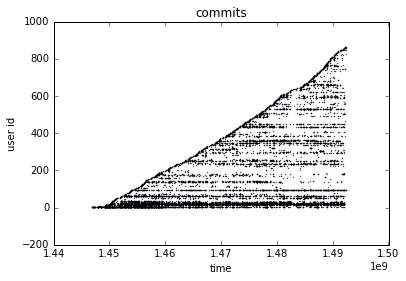

,commit,author_name,time_sec,subject,files_changed,lines_inserted,lines_deleted,id
16394,f41959c,Manjunath Kudlur,1446856078,TensorFlow-Initial-commit-of-TensorFlow-librar...,1900,391534,0,1
16393,cd9e60c,Manjunath Kudlur,1446863831,TensorFlow-Upstream-latest-changes-to-Git ...,72,1289,958,1
16387,71842da,Manjunath Kudlur,1447019816,TensorFlow-Upstream-latest-changes-to-git ...,14,110,110,1
16386,1d3874f,Manjunath Kudlur,1447024477,TensorFlow-Upstream-changes-to-git ...,22,430,405,1
16385,b2dc60e,Manjunath Kudlur,1447033308,TensorFlow-Upstream-changes-to-git ...,34,398,314,1
...,...,...,...,...,...,...,...,...
15,d53b5a4,Maxwell Paul Brickner,1492135693,Updated-the-link-to-tensorflow.org-to-use-http...,1,1,1,861
9,f83c3da,cfperez,1492210377,Correct-tf.matmul-keyword-reference-in-docs ...,1,3,3,862
8,b365526,Daniel Rasmussen,1492223657,Support-int32-idxs-in-sparse_tensor_dense_matm...,7,140,111,863
7,a09eeb2,wannabesrevenge,1492311574,Tensorboard-change-NPM-script-name-prepare-to-...,2,2,2,864


In [2]:
pd.options.display.max_rows = 10

path = "~/Prylar/clones/logs/"
# filename = "amazon-dsstne.csv"
# filename = "caffe.csv"
# filename = "CNTK.csv"
# filename = "convnetjs.csv"
# filename = "deeplearning4j.csv"
# filename = "h2o-3.csv"
# filename = "incubator-singa.csv"
# filename = "keras.csv"
# filename = "mxnet.csv"
# filename = "Paddle.csv"
filename = "tensorflow.csv"
# filename = "Theano.csv"
# filename = "torch7.csv"
# filename = "veles.csv"

df = pd.read_csv(path+filename,error_bad_lines=False)

df.fillna(0,inplace=True)

# Create a fictitious integer id based on first commit.
# (order has no downstream implications except easy plotting.)
id_col = 'id'
df[id_col] = df.groupby(["author_name"], group_keys=False).\
               apply(lambda g: g.time_sec.min().\
               astype(str)+g.author_name).\
               rank(method='dense').astype(int)

df.plot(kind='scatter', x='time_sec', y='id',s=0.1)
plt.title('commits')
plt.xlabel('time')
plt.ylabel('user id')
plt.show()
    
df.sort_values(['id','time_sec'],inplace=True)

df


In [3]:
# dt = "wallclock time", global timestep i.e 2012-01-01,...
abs_time_col='dt'
# t  = "elapsed time", local timestep i.e 0,1,2,10,...
t_col = 't_elapsed' 
discrete_time = True
# Does the explicit rows in dataset cover each sequence whole life?
sequences_terminated = False
numeric_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]

if discrete_time:
    # Convert nanosec to date
    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s').dt.date
    # Last timestep may be incomplete/not fully measured so drop it.
    df = df.loc[df[abs_time_col] <= df[abs_time_col].max()]
else:
    # Left as human readable format for readability.
#    df[abs_time_col] = pd.to_datetime(df['time_sec'],unit='s')
    df[abs_time_col] = df['time_sec']

# here we have the special case that a row indicates an event:
df['n_commits'] = 1

# Aggregate over the new datetime interval to get id,dt = unique key value pair
df = df.groupby([id_col,'author_name',abs_time_col],as_index=False).\
    agg(dict.fromkeys(numeric_cols, "sum"))#.reset_index()

# event = if something special happened i.e commit.
df['event'] =  (df.n_commits>0).astype(int)

if not sequences_terminated:
    # Assuming each sequence has its own start and is not terminated by last event:
    # Add last time that we knew the sequence was 'alive'.
    df = tr.df_join_in_endtime(df,
               per_id_cols=[id_col,'author_name'], 
               abs_time_col=abs_time_col,nanfill_val = 0)
    # Warning: fills unseen timesteps with 0
    
# Add "elapsed time" t_elapsed = 0,3,99,179,.. for each user. 
df[t_col] = df.groupby([id_col], group_keys=False).apply(lambda g: g.dt-g.dt.min())

if discrete_time:
    # Make it a well-behaved integer:
    # infer the discrete stepsize as the first component of the timedelta
    df[t_col] = df[t_col].dt.components.ix[:,0] 
else:
    # Add t_ix = 0,1,2,3,.. and set as primary user-time indicator.
    # if we pass t_elapsed as t_col downstream we'll pad between observed secs
    df['t_ix'] = df.groupby([id_col])[t_col].rank(method='dense').astype(int)-1
    t_col = 't_ix'

df

,id,author_name,dt,files_changed,n_commits,lines_deleted,lines_inserted,event,t_elapsed
865,1,Manjunath Kudlur,2015-11-07,1972,2,958,392823,1,0
866,1,Manjunath Kudlur,2015-11-08,36,2,515,540,1,1
867,1,Manjunath Kudlur,2015-11-09,68,7,1755,1888,1,2
868,1,Manjunath Kudlur,2015-11-20,1271,1,1067,18402,1,13
869,1,Manjunath Kudlur,2015-11-25,322,3,2888,5183,1,18
...,...,...,...,...,...,...,...,...,...
7506,863,Daniel Rasmussen,2017-04-15,7,1,111,140,1,0
862,863,Daniel Rasmussen,2017-04-17,0,0,0,0,0,2
7507,864,wannabesrevenge,2017-04-16,2,1,2,2,1,0
863,864,wannabesrevenge,2017-04-17,0,0,0,0,0,1


In [4]:
# Currently haven't found right paramtuning for ultra-high censoring.
# until then, let's focus on those who committed at least 10 days:
df['n_events_total']= df.groupby([id_col], group_keys=False).apply(lambda g: g.event.sum()+g.event-g.event)
df = df.loc[df['n_events_total'] > 10]

df

,id,author_name,dt,files_changed,n_commits,lines_deleted,lines_inserted,event,t_elapsed,n_events_total
865,1,Manjunath Kudlur,2015-11-07,1972,2,958,392823,1,0,91
866,1,Manjunath Kudlur,2015-11-08,36,2,515,540,1,1,91
867,1,Manjunath Kudlur,2015-11-09,68,7,1755,1888,1,2,91
868,1,Manjunath Kudlur,2015-11-20,1271,1,1067,18402,1,13,91
869,1,Manjunath Kudlur,2015-11-25,322,3,2888,5183,1,18,91
...,...,...,...,...,...,...,...,...,...,...
7377,766,Yong Tang,2017-03-23,1,1,0,26,1,19,11
7378,766,Yong Tang,2017-03-25,1,1,55,7,1,21,11
7379,766,Yong Tang,2017-03-26,1,1,9,9,1,22,11
7380,766,Yong Tang,2017-04-10,3,1,5,14,1,37,11


In [5]:
def _align_padded(padded,align_right):
    """aligns nan-padded temporal arrays to the right (align_right=True) or left.
    """
    padded = np.copy(padded)
    
    if len(padded.shape)==2:
        # (n_seqs,n_timesteps)
        seq_lengths = (False == np.isnan(padded)).sum(1)
        is_flat = True
        padded = np.expand_dims(padded,-1)
    elif len(padded.shape)==3:
        # (n_seqs,n_timesteps,n_features,..)
        seq_lengths = (False == np.isnan(padded[:,:,0])).sum(1)
        is_flat =False
    else:
        print 'not yet implemented'
        # TODO 
        
    n_seqs = padded.shape[0]
    n_timesteps = padded.shape[1]

    if align_right:
        for i in xrange(n_seqs):
            n = seq_lengths[i]
            if n>0:
                padded[i,(n_timesteps-n):,:] = padded[i,:n,:]
                padded[i,:(n_timesteps-n),:] = np.nan
    else:
        for i in xrange(n_seqs):
            n = seq_lengths[i]
            if n>0:
                padded[i,:n,:] = padded[i,(n_timesteps-n):,:]
                padded[i,n:,:] = np.nan
                        
    if is_flat:
        padded = np.squeeze(padded)
        
    return padded

def right_pad_to_left_pad(padded):
    return _align_padded(padded,align_right= True)

def left_pad_to_right_pad(padded):
    return _align_padded(padded,align_right= False)

# padded = tr.df_to_padded(df,["n_commits"],t_col=t_col)
# np.testing.assert_array_equal(padded,left_pad_to_right_pad(right_pad_to_left_pad(padded)))

# padded = np.copy(np.squeeze(padded))

# np.testing.assert_array_equal(padded,left_pad_to_right_pad(right_pad_to_left_pad(padded)))


# To trainable Tensor format
* map dataframes to tensor
* calculate tte-values
* Split into train/test
* normalize (using training data)
* hide truth from the model. Very important, otherwise it causes NaNs


In [6]:
# feature_cols = ["n_commits","files_changed", "lines_inserted","lines_deleted"]
feature_cols = ["n_commits"]
x = tr.df_to_padded(df,feature_cols,t_col=t_col)
events = tr.df_to_padded(df,['event'],t_col=t_col).squeeze() # For tte/censoring calculation 

n_timesteps = x.shape[1]
n_features  = x.shape[-1]
n_sequences = x.shape[0]
seq_lengths = (False==np.isnan(x[:,:,0])).sum(1)

x = np.log(x+1.) # log-kill outliers, decent method since we have positive data

if discrete_time:
    padded_t = None
else:
    padded_t = tr.df_to_padded(df,['t_elapsed'],t_col=t_col).squeeze()

y = np.zeros([n_sequences,n_timesteps,2])

# # Sort by seq length for pretty plots (OPTIONAL)
# new_ix = np.argsort(seq_lengths)
# x = x[new_ix,:,:]
# events = events[new_ix,:]
# seq_lengths = seq_lengths[new_ix]

# SPLIT 
# Simplest way to setup cross validation is to hide the t last days. bonus result is less censoring
# brutal method: simply right align all tensors and simply cut off the last 10% of timesteps. (ex last 30 days)

n_timesteps_to_hide = np.floor(n_timesteps*0.1).astype(int)

x_train      = left_pad_to_right_pad(right_pad_to_left_pad(x)[:,:(n_timesteps-n_timesteps_to_hide),:])
y_train      = left_pad_to_right_pad(right_pad_to_left_pad(y)[:,:(n_timesteps-n_timesteps_to_hide),:])
events_train = left_pad_to_right_pad(right_pad_to_left_pad(events)[:,:(n_timesteps-n_timesteps_to_hide)])

n_train     = x_train.shape[0]
seq_lengths_train = (False==np.isnan(x_train[:,:,0])).sum(1)

# Calculate TTE/censoring indicators after split.
y_train[:,:,0] = tr.padded_events_to_tte(events_train,discrete_time=discrete_time,t_elapsed=padded_t)
y_train[:,:,1] = tr.padded_events_to_not_censored(events_train,discrete_time)

y[:,:,0] = tr.padded_events_to_tte(events,discrete_time=discrete_time,t_elapsed=padded_t)
y[:,:,1] = tr.padded_events_to_not_censored(events,discrete_time)


#del x_, y_,seq_lengths

# NORMALIZE
x_train,means,stds = tr.normalize_padded(x_train)
x,_,_         = tr.normalize_padded(x,means,stds)

# HIDE the truth from the model:
if discrete_time:
    x = tr.shift_discrete_padded_features(x)
    x_train = tr.shift_discrete_padded_features(x_train)

    
# Used for initialization of alpha-bias:
tte_mean_train = np.nanmean(y_train[:,:,0])

print 'x_',x.shape,x.dtype
print 'y_',y.shape,y.dtype
print 'x_train',x_train.shape,x_train.dtype
print 'y_train',y_train.shape,y_train.dtype
print 'tte_mean_train: ', tte_mean_train

x_ (92, 528, 1) float64
y_ (92, 528, 2) float64
x_train (92, 476, 1) float64
y_train (92, 476, 2) float64
tte_mean_train:  23.1710377145


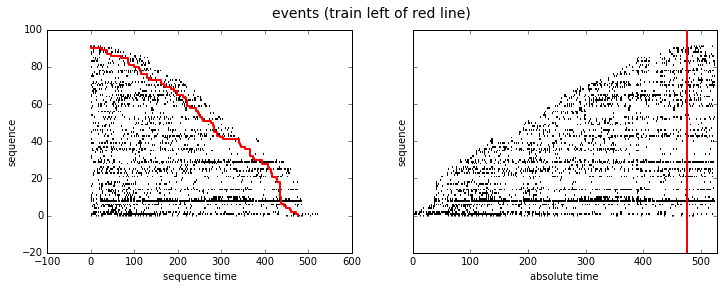

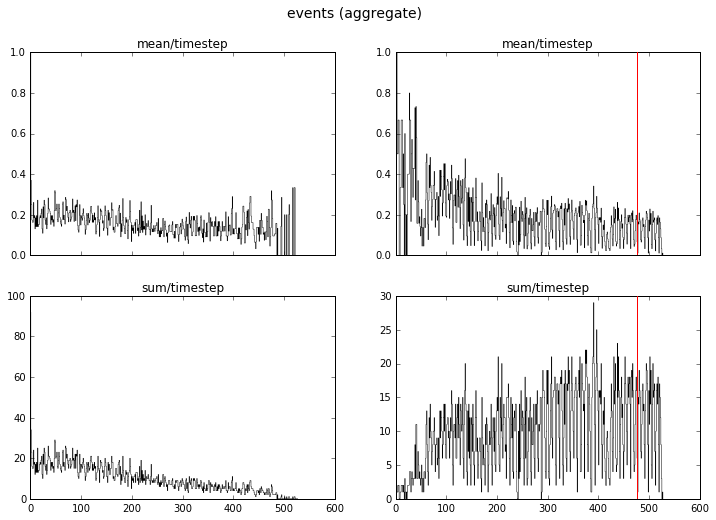

TRAINING SET


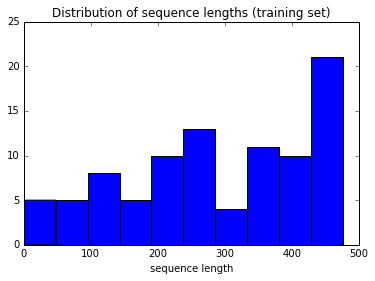

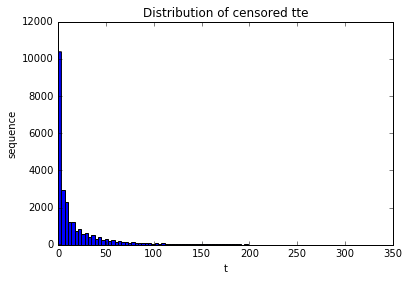

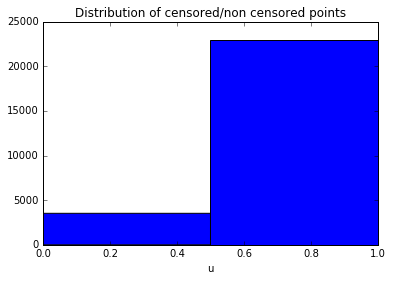

########## features


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


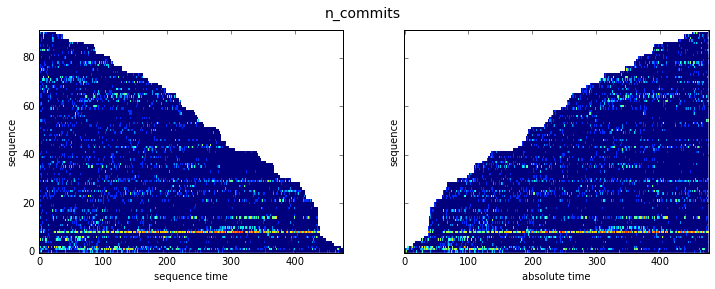

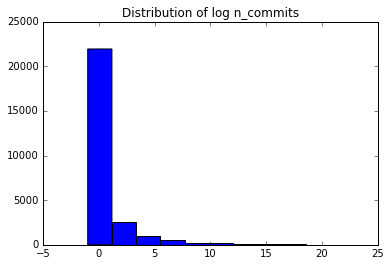

########## 


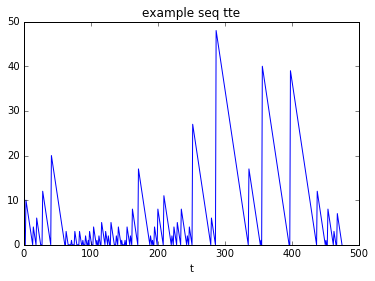

(None, None)

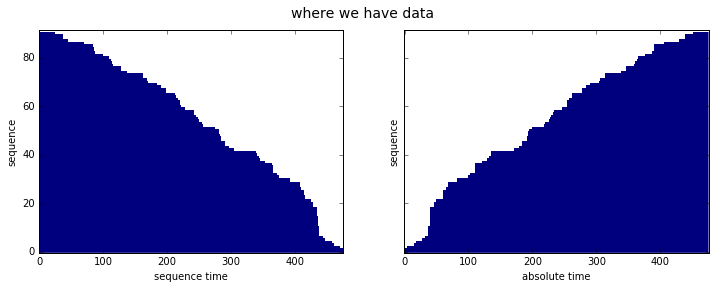

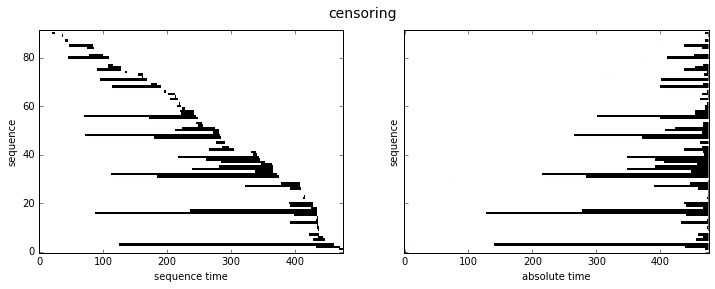

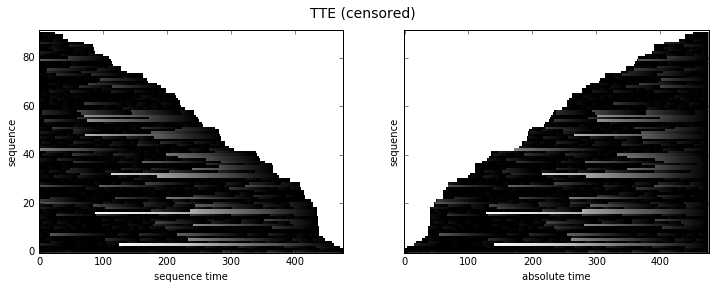

In [7]:
def timeline_plot(padded,title,cmap=None,plot=True):
    fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(12,4))
    
    ax[0].imshow(padded,interpolation='none', aspect='auto',cmap=cmap,origin='lower')    
    ax[0].set_ylabel('sequence');
    ax[0].set_xlabel('sequence time');
        
    im = ax[1].imshow(right_pad_to_left_pad(padded),interpolation='none', aspect='auto',cmap=cmap,origin='lower')  
    ax[1].set_ylabel('sequence');
    ax[1].set_xlabel('absolute time'); #(Assuming sequences end today)
    
    fig.suptitle(title,fontsize=14)
    if plot:
        fig.show()
        return None,None
    else:
        return fig,ax

def timeline_aggregate_plot(padded,title,plot=True):
    fig, ax = plt.subplots(ncols=2,nrows=2,sharex=True, sharey=False,figsize=(12,8))
    
    ax[0,0].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
    ax[0,0].set_title('mean/timestep')
    ax[1,0].plot(np.nansum(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
    ax[1,0].set_title('sum/timestep')
    padded = right_pad_to_left_pad(events)   
    ax[0,1].plot(np.nanmean(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
    ax[0,1].set_title('mean/timestep')
    ax[0,1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=1,zorder=10)
    ax[1,1].plot(np.nansum(padded,axis=0),lw=0.5,c='black',drawstyle='steps-post')
    ax[1,1].set_title('sum/timestep')

    fig.suptitle(title,fontsize=14)
    if plot:
        fig.show()
        return None,None
    else:
        return fig,ax
    
fig,ax = timeline_plot(events,"events (train left of red line)",cmap="Greys",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()
del fig,ax

fig, ax = timeline_aggregate_plot(events,'events (aggregate)',plot=False)
ax[1,1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=1,zorder=10)
plt.show()
del fig,ax

print 'TRAINING SET'
train_mask = (False==np.isnan(y_train[:,:,0]))

plt.hist(seq_lengths_train)
plt.title('Distribution of sequence lengths (training set)')
plt.xlabel('sequence length')
plt.show()

plt.hist(y_train[:,:,0][train_mask].flatten(),100)
plt.title('Distribution of censored tte')
plt.ylabel('sequence')
plt.xlabel('t')
plt.show()

plt.hist(y_train[:,:,1][train_mask].flatten(),2)
plt.title('Distribution of censored/non censored points')
plt.xlabel("u")
plt.show()

print '########## features'
for f in xrange(n_features):
    timeline_plot(x_train[:,:,f],feature_cols[f])
    plt.show()
    tmp = x_train[:,:,f].flatten()
    plt.hist(tmp[False==np.isnan(tmp)],10)
    plt.title('Distribution of log '+feature_cols[f])
    plt.show()
print '########## '
del tmp,train_mask

plt.plot(y_train[0,:,0])
plt.title('example seq tte')
plt.xlabel('t')
plt.show()

timeline_plot(y_train[:,:,1]-y_train[:,:,1],'where we have data')
######
timeline_plot(1-y_train[:,:,1],'censoring',cmap='Greys')
timeline_plot(1-y_train[:,:,0],'TTE (censored)',cmap='Greys')


# Train a WTTE-RNN
Everything done above could be done as one function get_data(). I kept it "in main" for transparency. Clearly this saves you time when you want to cut away the junk.
## TODO
    * Too much censoring causes NaNs (ex dataset: Theano repo)
    * Add masking-support for loss function to train on varying length batches
    * Find tuning to be able to use [-inf,inf] and non-centered activation functions like ReLu without causing NaNs
    * Is it useful to clip Alpha?
    * ... and everything else like best architecture, better output activation function etc.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers.wrappers import TimeDistributed

import keras.initializers as initializers
from keras.optimizers import RMSprop,adam

from keras.callbacks import History 
from keras.models import load_model

import wtte.tte_util as tte
import wtte.weibull as weibull
import wtte.wtte as wtte


Using Theano backend.


### Some thoughts on architecture:

* Output layer activation is everything. Initialize preferably as alpha=expected val, beta=1
* Bounded activations (e.g tanh) are more stable in short run but creates huge parameters and interfers with the recurrent counting process.
    * TODO get non-bounded (e.g relu) to work without causing NaN
* Think simple. Always try with pure ANN `model.add(TimeDistributed(Dense(...` first!
* Overfitting can be OK if we want to condense the history for analysis 


In [9]:
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/np.nanmean(y_train[:,:,1])
print 'init_alpha: ',init_alpha

np.random.seed(1)

model = Sequential()

model.add(TimeDistributed(Dense(3,activation='tanh'),input_shape=(None, n_features)))
model.add(LSTM(10, activation='tanh',return_sequences=True))
model.add(TimeDistributed(Dense(10,activation='tanh')))

model.add(Dense(2))
model.add(Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha, 
                                               "max_beta_value":4.0}))


loss = wtte.loss(kind='discrete').loss_function

lr = 0.05
model.compile(loss=loss, optimizer=adam(lr=lr))

model.summary()

loss_train = []
alpha_means = []
beta_means =  []
epoch_ok = True

def epoch():
    epoch_order = np.random.permutation(n_train)
    x_ = np.copy(np.expand_dims(x_train[epoch_order,:,:], axis=0))
    y_ = np.copy(np.expand_dims(y_train[epoch_order,:,:], axis=0)) 
    seq_lengths_ = np.copy(seq_lengths_train[epoch_order])

    predicted = model.predict(x_[0,:,:,:])
    predicted = predicted + np.expand_dims(predicted[:,:,0],-1)*0 # nan-mask
    alpha_means.append(np.nanmean(predicted[:,:,0]))
    beta_means.append(np.nanmean(predicted[:,:,1]))
    
    for i in xrange(n_train):
        this_seq_length = seq_lengths_[i]
        if this_seq_length>0:
            this_loss = model.train_on_batch(x_[:,i,:this_seq_length,:], 
                                             y_[:,i,:this_seq_length,:])

            loss_train.append(this_loss)
            
            if np.isnan(this_loss):
                print 'induced NANs on iteration ',len(loss_train)
                return False
        

    return True

init_alpha:  27.3083557191


/usr/local/lib/python2.7/site-packages/keras/layers/core.py:640: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, None, 2)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 3)           6         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 10)          560       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          110       
_________________________________________________________________
dense_3 (Dense)              (None, None, 2)           22        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 698.0
Trainable params: 698.0
Non-trainable params: 0.0
_________________________________________________________________


In [10]:
#model.load_weights('./model_checkpoint.h5', by_name=False)

epoch  0  training step  0  lr  0.0485000014305


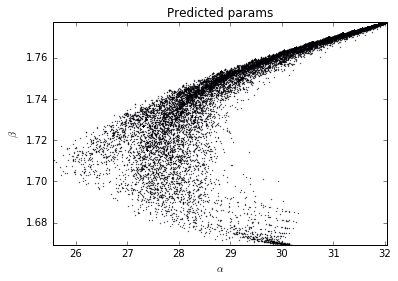

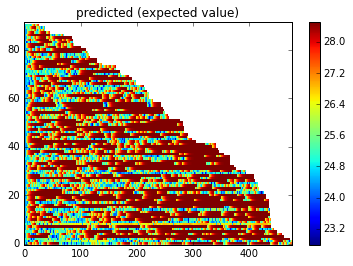

MODEL CHECKPOINT SAVED
alpha mean  30.4645 beta mean  1.75882
epoch  1  training step  91  lr  0.0470449998975
alpha mean  22.2246 beta mean  1.10591
epoch  2  training step  182  lr  0.0456336513162
alpha mean  22.3478 beta mean  0.947732
epoch  3  training step  273  lr  0.0442646406591
alpha mean  26.2975 beta mean  0.856571
epoch  4  training step  364  lr  0.0429367013276
alpha mean  25.1823 beta mean  0.816156
epoch  5  training step  455  lr  0.0416486002505
alpha mean  25.1273 beta mean  0.784002
epoch  6  training step  546  lr  0.0403991416097
alpha mean  24.1977 beta mean  0.764166
epoch  7  training step  637  lr  0.0391871668398
alpha mean  24.7238 beta mean  0.747125
epoch  8  training step  728  lr  0.0380115546286
alpha mean  23.344 beta mean  0.735218
epoch  9  training step  819  lr  0.0368712060153
alpha mean  23.9813 beta mean  0.7211
epoch  10  training step  910  lr  0.0357650704682


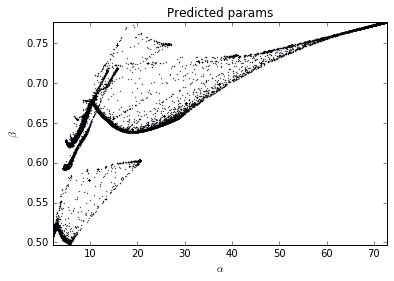

alpha mean  24.9664 beta mean  0.717013
epoch  11  training step  1001  lr  0.034692119807
alpha mean  25.7985 beta mean  0.709843
epoch  12  training step  1092  lr  0.033651355654
alpha mean  26.8361 beta mean  0.69829
epoch  13  training step  1183  lr  0.032641813159
alpha mean  26.8074 beta mean  0.693573
epoch  14  training step  1274  lr  0.0316625609994
alpha mean  26.4137 beta mean  0.691751
epoch  15  training step  1365  lr  0.0307126827538
alpha mean  27.069 beta mean  0.687529
epoch  16  training step  1456  lr  0.029791302979
alpha mean  26.8594 beta mean  0.687252
epoch  17  training step  1547  lr  0.0288975629956
alpha mean  26.682 beta mean  0.685735
epoch  18  training step  1638  lr  0.028030635789
alpha mean  26.5311 beta mean  0.687669
epoch  19  training step  1729  lr  0.0271897166967
alpha mean  26.552 beta mean  0.683723
epoch  20  training step  1820  lr  0.0263740252703


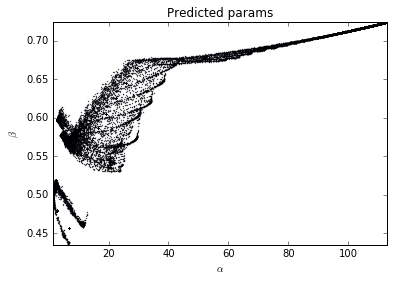

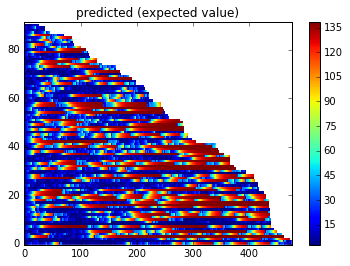

MODEL CHECKPOINT SAVED
alpha mean  27.4876 beta mean  0.680841
epoch  21  training step  1911  lr  0.0255828052759
alpha mean  27.2604 beta mean  0.680506
epoch  22  training step  2002  lr  0.0248153209686
alpha mean  27.0326 beta mean  0.68143
epoch  23  training step  2093  lr  0.024070860818
alpha mean  27.1346 beta mean  0.679293
epoch  24  training step  2184  lr  0.0233487356454
alpha mean  27.2896 beta mean  0.677699
epoch  25  training step  2275  lr  0.0226482730359
alpha mean  27.5282 beta mean  0.676372
epoch  26  training step  2366  lr  0.0219688247889
alpha mean  27.5903 beta mean  0.675824
epoch  27  training step  2457  lr  0.0213097594678
alpha mean  27.3436 beta mean  0.672502
epoch  28  training step  2548  lr  0.0206704679877
alpha mean  27.3189 beta mean  0.671156
epoch  29  training step  2639  lr  0.0200503543019
alpha mean  27.028 beta mean  0.672391
epoch  30  training step  2730  lr  0.0194488428533


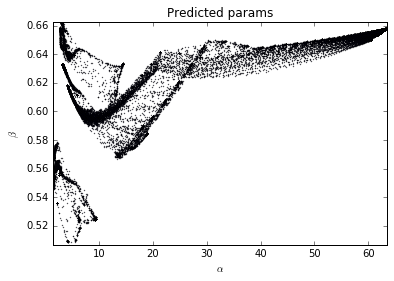

alpha mean  26.9873 beta mean  0.670613
epoch  31  training step  2821  lr  0.0188653767109
alpha mean  26.7796 beta mean  0.671266
epoch  32  training step  2912  lr  0.0182994157076
alpha mean  26.5871 beta mean  0.671779
epoch  33  training step  3003  lr  0.0177504345775
alpha mean  26.6833 beta mean  0.670247
epoch  34  training step  3094  lr  0.0172179210931
alpha mean  26.7701 beta mean  0.670109
epoch  35  training step  3185  lr  0.0167013835162
alpha mean  26.8099 beta mean  0.670156
epoch  36  training step  3276  lr  0.0162003412843
alpha mean  26.7594 beta mean  0.670279
epoch  37  training step  3367  lr  0.0157143305987
alpha mean  26.822 beta mean  0.671357
epoch  38  training step  3458  lr  0.0152429016307
alpha mean  26.8849 beta mean  0.672103
epoch  39  training step  3549  lr  0.014785614796
alpha mean  26.9416 beta mean  0.672389
epoch  40  training step  3640  lr  0.0143420463428


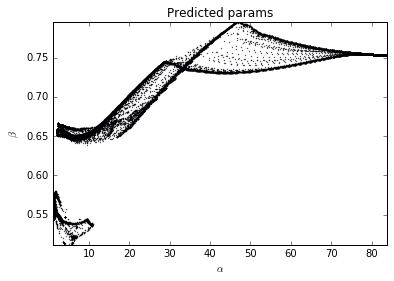

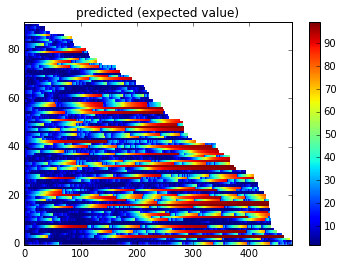

MODEL CHECKPOINT SAVED
alpha mean  26.9484 beta mean  0.672516
epoch  41  training step  3731  lr  0.0139117846265
alpha mean  26.9255 beta mean  0.67228
epoch  42  training step  3822  lr  0.0134944310412
alpha mean  27.1277 beta mean  0.67172
epoch  43  training step  3913  lr  0.0130895981565
alpha mean  27.4436 beta mean  0.6715
epoch  44  training step  4004  lr  0.0126969097182
alpha mean  27.3035 beta mean  0.67238
epoch  45  training step  4095  lr  0.0123160025105
alpha mean  27.3968 beta mean  0.672183
epoch  46  training step  4186  lr  0.0119465226308
alpha mean  27.3026 beta mean  0.672819
epoch  47  training step  4277  lr  0.0115881273523
alpha mean  27.4699 beta mean  0.67328
epoch  48  training step  4368  lr  0.0112404832616
alpha mean  27.4273 beta mean  0.67346
epoch  49  training step  4459  lr  0.0109032690525
alpha mean  27.3627 beta mean  0.673414
epoch  50  training step  4550  lr  0.0105761708692


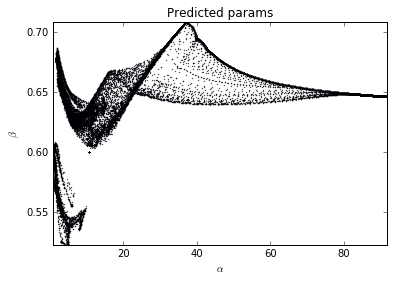

alpha mean  27.3252 beta mean  0.672679
epoch  51  training step  4641  lr  0.0102588860318
alpha mean  27.2931 beta mean  0.673147
epoch  52  training step  4732  lr  0.00995111931115
alpha mean  27.2922 beta mean  0.67276
epoch  53  training step  4823  lr  0.00965258572251
alpha mean  27.2261 beta mean  0.673644
epoch  54  training step  4914  lr  0.00936300773174
alpha mean  27.3328 beta mean  0.673329
epoch  55  training step  5005  lr  0.00908211804926
alpha mean  27.5461 beta mean  0.673293
epoch  56  training step  5096  lr  0.00880965404212
alpha mean  27.569 beta mean  0.673254
epoch  57  training step  5187  lr  0.00854536425322
alpha mean  27.8179 beta mean  0.673616
epoch  58  training step  5278  lr  0.00828900374472
alpha mean  27.9382 beta mean  0.673427
epoch  59  training step  5369  lr  0.00804033316672
alpha mean  28.0493 beta mean  0.672895
epoch  60  training step  5460  lr  0.00779912341386


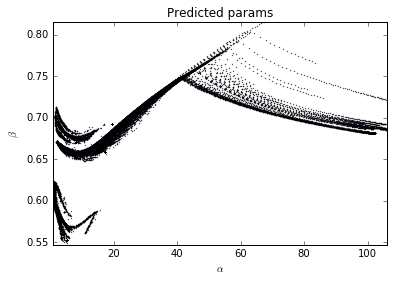

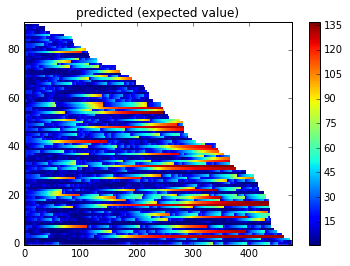

MODEL CHECKPOINT SAVED
alpha mean  28.0115 beta mean  0.6729
epoch  61  training step  5551  lr  0.00756514957175
alpha mean  28.024 beta mean  0.673154
epoch  62  training step  5642  lr  0.00733819510788
alpha mean  28.047 beta mean  0.673429
epoch  63  training step  5733  lr  0.00711804954335
alpha mean  28.0146 beta mean  0.673527
epoch  64  training step  5824  lr  0.0069045079872
alpha mean  28.0747 beta mean  0.673588
epoch  65  training step  5915  lr  0.00669737253338
alpha mean  28.2542 beta mean  0.673387
epoch  66  training step  6006  lr  0.00649645132944
alpha mean  28.425 beta mean  0.673417
epoch  67  training step  6097  lr  0.00630155811086
alpha mean  28.6022 beta mean  0.673321
epoch  68  training step  6188  lr  0.00611251126975
alpha mean  28.6523 beta mean  0.673878
epoch  69  training step  6279  lr  0.00592913571745
alpha mean  28.853 beta mean  0.673721
epoch  70  training step  6370  lr  0.00575126195326


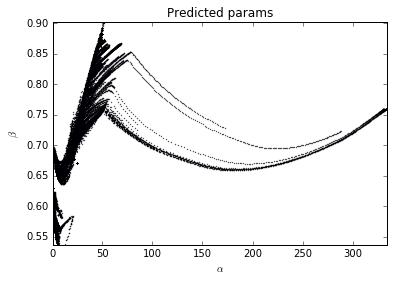

alpha mean  28.9167 beta mean  0.674121
epoch  71  training step  6461  lr  0.00557872373611
alpha mean  29.0828 beta mean  0.674268
epoch  72  training step  6552  lr  0.00541136227548
alpha mean  29.3599 beta mean  0.674366
epoch  73  training step  6643  lr  0.00524902157485
alpha mean  29.6983 beta mean  0.674406
epoch  74  training step  6734  lr  0.00509155075997
alpha mean  29.8037 beta mean  0.674518
epoch  75  training step  6825  lr  0.00493880407885
alpha mean  29.9121 beta mean  0.674509
epoch  76  training step  6916  lr  0.00479063997045
alpha mean  30.0887 beta mean  0.675108
epoch  77  training step  7007  lr  0.0046469210647
alpha mean  30.0766 beta mean  0.675553
epoch  78  training step  7098  lr  0.00450751325116
alpha mean  30.294 beta mean  0.675715
epoch  79  training step  7189  lr  0.00437228800729
alpha mean  30.7039 beta mean  0.675995
epoch  80  training step  7280  lr  0.0042411191389


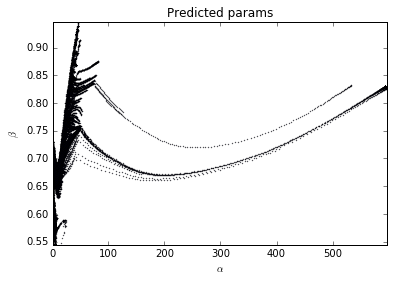

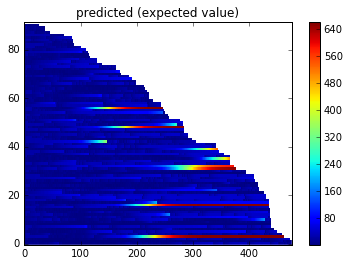

MODEL CHECKPOINT SAVED
alpha mean  30.7807 beta mean  0.676435
epoch  81  training step  7371  lr  0.00411388557404
alpha mean  30.9684 beta mean  0.676568
epoch  82  training step  7462  lr  0.00399046903476
alpha mean  31.2419 beta mean  0.676726
epoch  83  training step  7553  lr  0.00387075496837
alpha mean  31.5704 beta mean  0.677211
epoch  84  training step  7644  lr  0.00375463231467
alpha mean  31.5784 beta mean  0.677703
epoch  85  training step  7735  lr  0.00364199327305
alpha mean  31.8758 beta mean  0.677647
epoch  86  training step  7826  lr  0.00353273353539
alpha mean  32.1713 beta mean  0.678044
epoch  87  training step  7917  lr  0.00342675158754
alpha mean  32.5088 beta mean  0.678424
epoch  88  training step  8008  lr  0.00332394894212
alpha mean  32.5995 beta mean  0.678878
epoch  89  training step  8099  lr  0.00322423060425
alpha mean  32.9201 beta mean  0.679388
epoch  90  training step  8190  lr  0.00312750367448


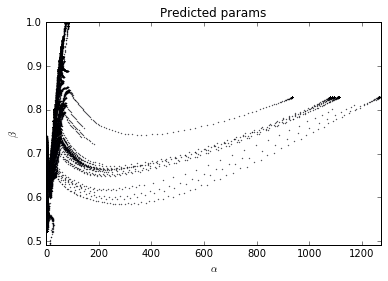

alpha mean  33.3956 beta mean  0.679744
epoch  91  training step  8281  lr  0.00303367851302
alpha mean  33.9006 beta mean  0.680125
epoch  92  training step  8372  lr  0.00294266827404
alpha mean  34.4996 beta mean  0.669033
epoch  93  training step  8463  lr  0.0028543882072
alpha mean  35.0811 beta mean  0.67181
epoch  94  training step  8554  lr  0.00276875658892
alpha mean  35.6304 beta mean  0.672678
epoch  95  training step  8645  lr  0.00268569379114
alpha mean  36.1013 beta mean  0.67412
epoch  96  training step  8736  lr  0.00260512297973
alpha mean  36.853 beta mean  0.6748
epoch  97  training step  8827  lr  0.00252696918324
alpha mean  37.3333 beta mean  0.675887
epoch  98  training step  8918  lr  0.00245116022415
alpha mean  38.167 beta mean  0.676827
epoch  99  training step  9009  lr  0.00237762532197
alpha mean  38.8118 beta mean  0.677868


In [11]:
# store/load models since we may encounter NaNs or training interrupted.
for i in xrange(100):
    lr = lr*0.97
    K.set_value(model.optimizer.lr, lr)

    print 'epoch ',i,' training step ',len(loss_train),' lr ',K.eval(model.optimizer.lr)
    if i%10==0 and epoch_ok:

        predicted = model.predict(x_train)
        predicted[:,:,1]=predicted[:,:,1]+predicted[:,:,0]*0# lazy re-add NAN-mask
        
        plt.scatter(predicted[:,:,0],predicted[:,:,1],s=0.1)
        plt.title('Predicted params')
        plt.xlim([np.nanmin(predicted[:,:,0]),np.nanmax(predicted[:,:,0])])
        plt.ylim([np.nanmin(predicted[:,:,1]),np.nanmax(predicted[:,:,1])])
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$\beta$')
        plt.show()

        if i%20==0:
            expected_val = weibull.mean(predicted[:,:,0], predicted[:,:,1])
            plt.imshow(expected_val,aspect='auto',interpolation="none",origin='lower')  
            plt.colorbar()
            plt.title('predicted (expected value)')
            plt.show()

            model.save_weights('./model_checkpoint.h5')  # creates a HDF5 file 'my_model.h5'
            print 'MODEL CHECKPOINT SAVED'
    
    epoch_ok = epoch()
    if epoch_ok:
        n = min([n_train,len(loss_train)])
        print 'alpha mean ',np.mean(alpha_means[-n:]),'beta mean ',np.mean(beta_means[-n:])
    else:
        model.load_weights('./model_checkpoint.h5', by_name=False)
        print 'RESTORING MODEL FROM CHECKPOINT'


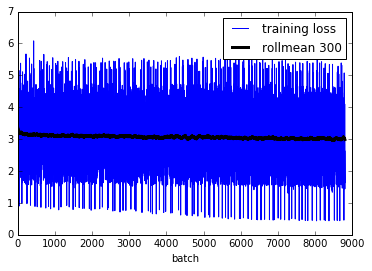

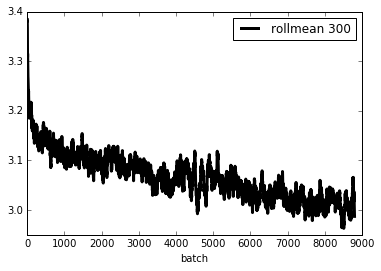

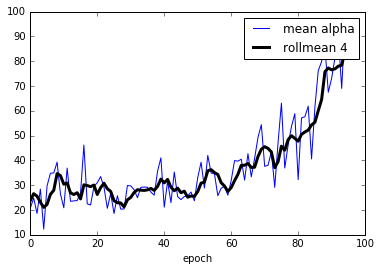

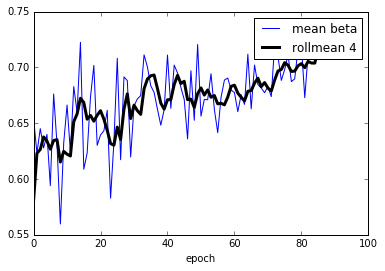

In [12]:
# Per batch
n_roll_steps = 300
offset = 300
plt.plot(loss_train[offset:], label='training loss')
plt.plot(tte.roll_fun(x=loss_train,fun=np.mean,size=n_roll_steps)[offset:],color='k',lw=3,label='rollmean '+str(n_roll_steps))
plt.xlabel('batch')
plt.legend()
plt.show() 

#plt.plot(loss_train[offset:], label='training loss')
plt.plot(tte.roll_fun(x=loss_train,fun=np.mean,size=n_roll_steps)[offset:],color='k',lw=3,label='rollmean '+str(n_roll_steps))
plt.xlabel('batch')
plt.legend()
plt.show() 

# Per epoch
n_roll_steps = 4
offset = 4
plt.plot(alpha_means[offset:], label='mean alpha')
plt.plot(tte.roll_fun(x=alpha_means,fun=np.mean,size=n_roll_steps)[offset:],color='k',lw=3,label='rollmean '+str(n_roll_steps))
plt.legend()
plt.xlabel('epoch')
plt.show()

plt.plot(beta_means[offset:], label='mean beta')
plt.plot(tte.roll_fun(x=beta_means,fun=np.mean,size=n_roll_steps)[offset:],color='k',lw=3,label='rollmean '+str(n_roll_steps))
plt.legend()
plt.xlabel('epoch')
plt.show()


## Predict 

In [13]:
predicted = model.predict(x)
predicted[:,:,1]=predicted[:,:,1]+predicted[:,:,0]*0# lazy re-add NAN-mask
print(predicted.shape)

# Here you'd stop after transforming to dataframe and piping it back to some database
tr.padded_to_df(predicted,column_names=["alpha","beta"],dtypes=[float,float],ids=pd.unique(df.id))

(92, 528, 2)


,id,t,alpha,beta
0,1,0,0.147621,0.718135
1,1,1,4.532027,0.514450
2,1,2,2.905406,0.563653
3,1,3,2.617541,0.572243
4,1,4,4.626315,0.672890
...,...,...,...,...
31324,766,41,9.950050,0.666970
31325,766,42,11.115096,0.659072
31326,766,43,12.343697,0.672568
31327,766,44,13.576956,0.675572


But we keep on plotting
# Individual sequence

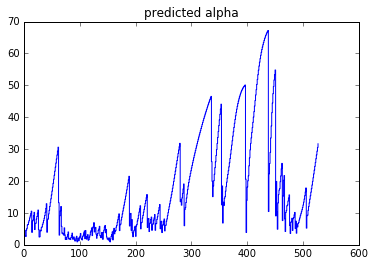

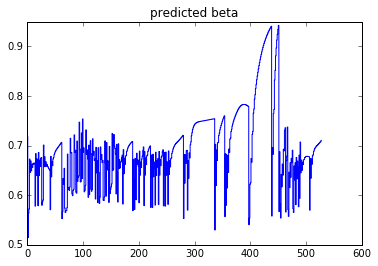

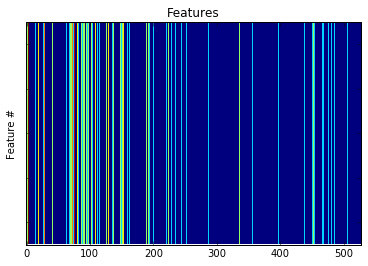

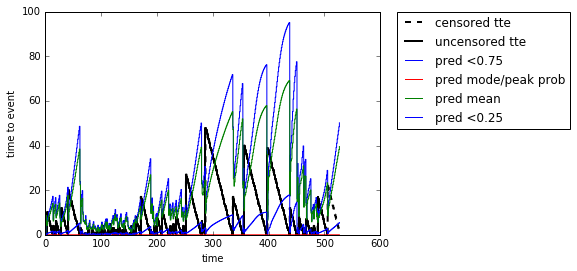

In [14]:
drawstyle = 'steps-post'

batch_indx =0 # Guido
#batch_indx =-1 # latest user

this_seq_len = seq_lengths[batch_indx]
a = predicted[batch_indx,:this_seq_len,0]
b = predicted[batch_indx,:this_seq_len,1]
t = np.array(xrange(len(a)))
x_this = x[batch_indx,:this_seq_len,:]

this_tte = y[batch_indx,:this_seq_len,0]
u = y[batch_indx,:this_seq_len,1]>0

plt.plot(a,drawstyle='steps-post')
plt.title('predicted alpha')
plt.show()
plt.plot(b,drawstyle='steps-post')
plt.title('predicted beta')
plt.show()

fig,ax = plt.subplots()
ax.imshow(x_this.T,origin='lower',interpolation='none',aspect='auto')
ax.set_ylabel('Feature #')
ax.set_title('Features')
ax.set_ylim(-0.5, x_this.shape[-1]-0.5)
ax.set_yticklabels(xrange(x_this.shape[-1]))
ax.set_xlim(-0.5, x_this.shape[0]-0.5)
plt.show()

plt.plot(this_tte,label='censored tte',color='black',linestyle='dashed',linewidth=2,drawstyle=drawstyle)
plt.plot(t[u],this_tte[u],label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)

plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)
plt.xlabel('time')
plt.ylabel('time to event')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Aggregate view

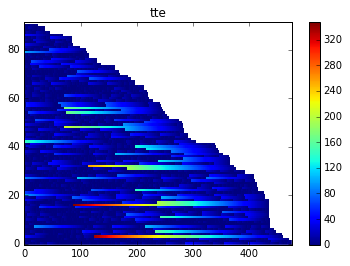

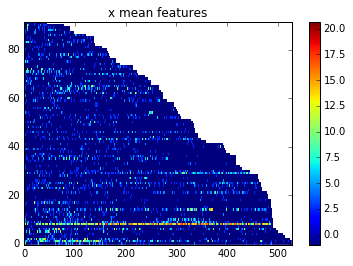

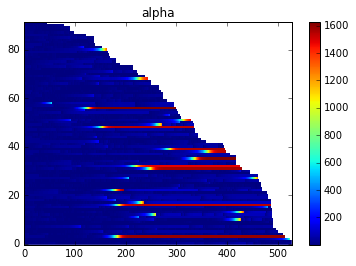

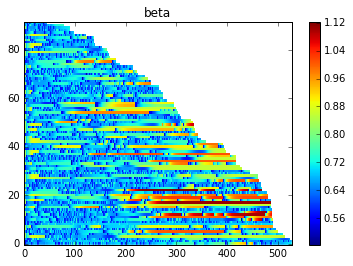

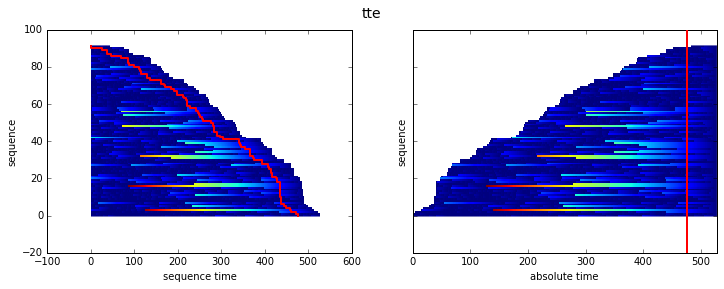

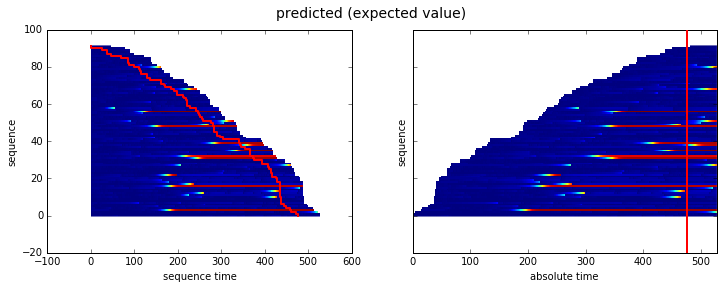

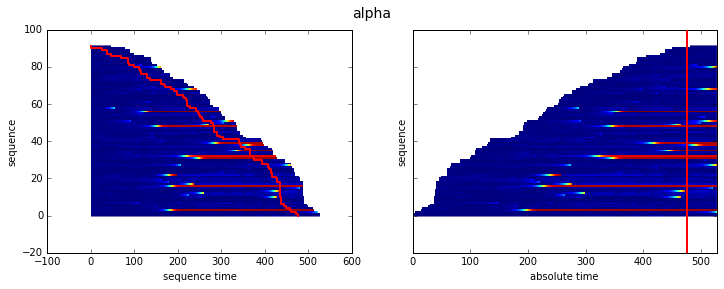

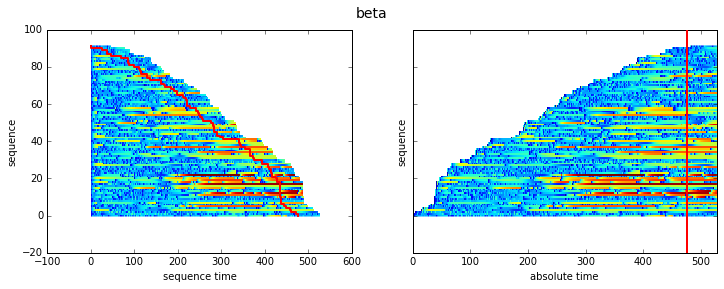

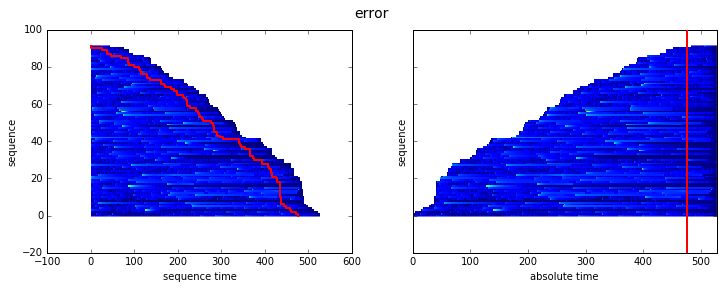

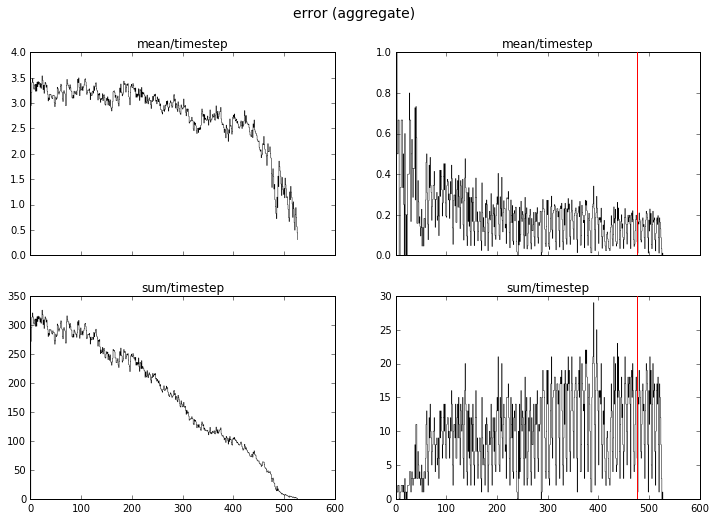

In [15]:
plt.imshow(y_train[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('tte')
plt.colorbar()
plt.show()

plt.imshow(x.sum(axis=-1),aspect='auto',interpolation="none",origin='lower')  
plt.title('x mean features')
plt.colorbar()
plt.show()

plt.imshow(predicted[:,:,0],aspect='auto',interpolation="none",origin='lower')  
plt.title('alpha')
plt.colorbar()
plt.show()
plt.imshow(predicted[:,:,1],aspect='auto',interpolation="none",origin='lower')  
plt.title('beta')
plt.colorbar()
plt.show()

fig,ax = timeline_plot(y[:,:,0],"tte",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()

padded = weibull.mean(a=predicted[:,:,0],b=predicted[:,:,1])
fig,ax = timeline_plot(padded,"predicted (expected value)",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()

fig,ax = timeline_plot(predicted[:,:,0],"alpha",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()

fig,ax = timeline_plot(predicted[:,:,1],"beta",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()

padded = -weibull.discrete_loglik(a=predicted[:,:,0],b=predicted[:,:,1],t=y[:,:,0],u=y[:,:,1],equality=False)
fig,ax = timeline_plot(padded,"error",plot=False)
ax[0].plot(seq_lengths_train,xrange(n_sequences),c="red",linewidth=2,zorder=10,drawstyle = 'steps-post')
ax[1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=2,zorder=10)
plt.show()
    
fig, ax = timeline_aggregate_plot(padded,'error (aggregate)',plot=False)
ax[1,1].axvline(x=n_timesteps-n_timesteps_to_hide,c="red",linewidth=1,zorder=10)
plt.show()
del fig,ax


# Scatter

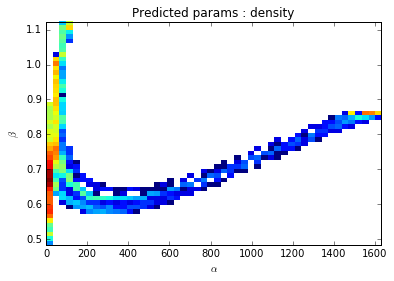

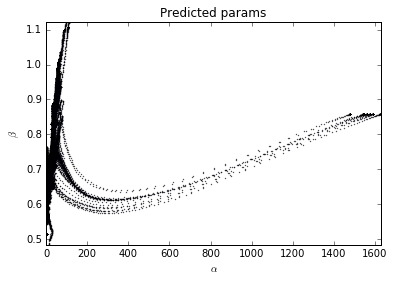

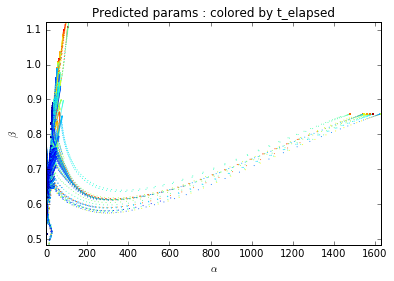

In [16]:
# Alpha and beta projections

t_flat = np.cumsum(~np.isnan(predicted[:,:,0]),axis=1)[~np.isnan(predicted[:,:,0])].flatten()
alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

## log-alpha typically makes more sense.
# alpha_flat = np.log(alpha_flat)

from matplotlib.colors import LogNorm
counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
plt.title('Predicted params : density')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

plt.scatter(alpha_flat,beta_flat,s=0.1)
plt.title('Predicted params')
plt.xlim([alpha_flat.min(),alpha_flat.max()])
plt.ylim([beta_flat.min(),beta_flat.max()])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

var = t_flat
plt.scatter(alpha_flat,
            beta_flat,
            s=1.0,c=var.flatten(),lw = 0)
plt.title('Predicted params : colored by t_elapsed')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.xlim([alpha_flat.min(),alpha_flat.max()])
plt.ylim([beta_flat.min(),beta_flat.max()])
plt.show()



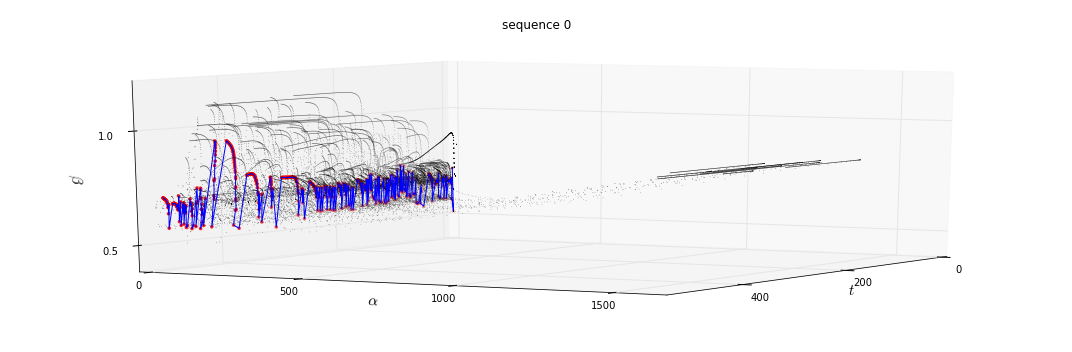

In [17]:
# t_elapsed, "time since start"
t = np.cumsum(~np.isnan(predicted[:,:,0]),axis=1)+predicted[:,:,0]*0

# dt or "wallclock time"
# t = t+np.expand_dims(np.isnan(predicted[:,:,0]).sum(1),-1)

predicted_alpha = predicted[:,:,0]
predicted_beta =  predicted[:,:,1]+predicted[:,:,0]*0

## log-alpha typically makes more sense.
# predicted_alpha = np.log(predicted_alpha)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

scale_fig = 1.

fig=plt.figure(figsize=(scale_fig*15,scale_fig*5))

# Set the bottom and top outside the actual figure limits, 
# to stretch the 3D axis

ax = fig.add_subplot(111, projection='3d')


# Change the viewing angle to an agreeable one
#ax.view_init(8,320)
#ax.view_init(20,2)
ax.view_init(10,30)


ax = fig.gca(projection='3d')

#for seq in xrange(predicted_alpha.shape[0]):
for seq in [0]:
    plt.cla()
    # highlight path for one sequence
    ax.plot(
           t[seq,:],
           predicted_alpha[seq,:],
           predicted_beta[seq,:],zorder=1
       )
    # plot all others
    ax.scatter(
           t[:,:],
           predicted_alpha[:,:],
           predicted_beta[:,:],
           c='black',lw=0,s=0.5,zorder=0
       )
    # highlight points for one sequence
    ax.scatter(
           t[seq,:],
           predicted_alpha[seq,:],
           predicted_beta[seq,:],
           c='red',lw=0,s=50, marker ='.',zorder=2
       )
    
    ax.set_xlim3d([0,np.nanmax(t)])
    ax.set_ylim3d([0,np.nanmax(predicted_alpha).astype(int)+1])
    
    ax.set_xlabel(r'$t$',fontsize=15)
    ax.set_ylabel(r'$\alpha$',fontsize=15)
    ax.set_zlabel(r'$\beta$',fontsize=15)
    ax.set_title('sequence '+str(seq),fontsize=12)
    
    #ax.invert_xaxis()
    ax.locator_params(axis='both',nbins=4)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    fig.tight_layout()


# Calibration

For the uncensored points we assume F(Y) to be uniform. Deviations means we have problem of calibration (which we have obviously below.)

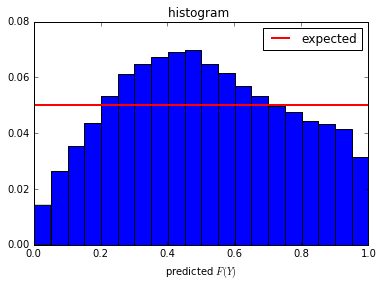

In [18]:
n_bins = 20
cmf = weibull.cmf(t=y[:,:,0],a=predicted[:,:,0],b=predicted[:,:,1])

cmf = cmf[(~np.isnan(y[:,:,1]))*(y[:,:,1]==1) ]

plt.hist(cmf.flatten(),n_bins,weights = np.ones_like(cmf.flatten())/float(len(cmf.flatten())))
plt.xlabel(r'predicted $F(Y)$')
plt.title('histogram ')
plt.axhline(1.0/n_bins,lw=2,c='red',label='expected')
plt.locator_params(axis='both',nbins=5)
plt.legend()
plt.show()
